In [1]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE

all_files = glob.glob("roll_data/*-out.csv")

df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

season = 12
df = df[df['season'] == season]
len(df)

12758

In [2]:
def calc_vibes(df, prefix):
    buoy = df[prefix + "_buoyancy"]# * df[prefix + "_mul"]
    press = df[prefix + "_pressurization"]# * df[prefix + "_mul"]
    cinn = df[prefix + "_cinnamon"]# * df[prefix + "_mul"]

    freq = 6 + (buoy * 10).round()
    phase = math.pi * ((2/freq) * dfc["day"] + 0.5)
    vibes = 0.5 * (press + cinn) * np.sin(phase) - (0.5 * press) + (0.5 * cinn)
    return vibes

def get_pitcher_mul(row):
    pm = str(row["pitcher_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in pm:
        mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    if "UNDERPERFORMING" in pm:
        mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    if "TRAVELING" in ptm:
        # pass # traveling just doesn't do anything on pitchers?
        if not row["top_of_inning"]:
            mul += 0.05
    if "HIGH_PRESSURE" in ptm:
        # i messed up baserunner_count lol, so it's a string
        if row["weather"] == 18 and str(row["baserunner_count"]) != "[]":
            mul += 0.25
    if "GROWTH" in ptm:
        mul += min(0.05, 0.05 * (row["day"] / 99))
        # pass # growth doesn't do anything on pitchers either
    if "SINKING_SHIP" in ptm:
        mul += (14 - row["pitching_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in ptm and row["weather"] == 11:
        mul += 0.5
    return mul

def get_batter_mul(row):
    bm = str(row["batter_mods"])
    btm = str(row["batting_team_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in bm:
        mul += 0.2
    if "OVERPERFORMING" in btm:
        mul += 0.2
    if "UNDERPERFORMING" in bm:
        mul -= 0.2
    if "UNDERPERFORMING" in btm:
        mul -= 0.2
    if "TRAVELING" in btm:
        pass
        # if row["top_of_inning"]:
            # this doesn't seem to do anything if it's here or not here
            # mul += 0.05
    if "GROWTH" in btm:
        # mul += min(0.05, 0.05 * (row["day"] / 99))
        pass
    if "HIGH_PRESSURE" in btm:
        if row["weather"] == 18 and str(row["baserunner_count"]) != "[]":
            mul += 0.25
    if "SINKING_SHIP" in btm:
        mul += (14 - row["batting_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in btm and row["weather"] == 11:
        mul += 0.5
    if "CHUNKY" in bm and row["weather"] == 10:
        # todo: handle, in peanuts weather
#         pass
        mul += 1.0
    if "SMOOTH" in bm and row["weather"] == 10:
        # todo: handle, in peanuts weather
        pass
    if "ON_FIRE" in bm:
        # todo: handle
        mul += 2.0
#         pass
    return mul

def get_fielder_mul(row):
    fm = str(row["defender_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in fm:
        mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    if "UNDERPERFORMING" in fm:
        mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    if "TRAVELING" in ptm:
        # pass # traveling just doesn't do anything on pitchers?
        if not row["top_of_inning"]:
            mul += 0.05
    if "HIGH_PRESSURE" in ptm:
        # i messed up baserunner_count lol, so it's a string
        if row["weather"] == 18 and str(row["baserunner_count"]) != "[]":
            mul += 0.25
    if "GROWTH" in ptm:
        mul += min(0.05, 0.05 * (row["day"] / 99))
        # pass # growth doesn't do anything on pitchers either
    if "SINKING_SHIP" in ptm:
        mul += (14 - row["pitching_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in ptm and row["weather"] == 11:
        mul += 0.5
    if "SHELLED" in fm:
        # is it this, or is it "mul = 0", I wonder
        mul -= 1.0
    return mul

In [3]:
df["batter_mul"] = df.apply(get_batter_mul, axis=1)
df["pitcher_mul"] = df.apply(get_pitcher_mul, axis=1)
df["fielder_mul"] = df.apply(get_fielder_mul, axis=1)

In [4]:
df['baserunner_n'] = [int(np.floor(len(x)/40)) for x in df.loc[:, 'baserunner_count']]

df.loc[df["pitcher_mods"].astype(str).str.contains("SCATTERED"),"pitcher_vibes"] = 0
df.loc[df["batter_mods"].astype(str).str.contains("SCATTERED"),"batter_vibes"] = 0
df.loc[df["defender_mods"].astype(str).str.contains("SCATTERED"),"defender_vibes"] = 0

for attr in ['batter_buoyancy', 'batter_divinity', 'batter_martyrdom', 'batter_moxie', 'batter_musclitude', 'batter_patheticism', 'batter_thwackability', 'batter_tragicness', 'batter_coldness', 'batter_overpowerment', 'batter_ruthlessness', 'batter_shakespearianism', 'batter_suppression', 'batter_unthwackability', 'batter_base_thirst', 'batter_continuation', 'batter_ground_friction', 'batter_indulgence', 'batter_laserlikeness', 'batter_anticapitalism', 'batter_chasiness', 'batter_omniscience', 'batter_tenaciousness', 'batter_watchfulness', 'batter_pressurization', 'batter_cinnamon']:
    df[attr] = df[attr] * df['batter_mul']
    df[attr+'_with_vibe'] = df[attr] * (1 + 0.2 * df['batter_vibes'])
df = df.copy()
for attr in ['pitcher_buoyancy', 'pitcher_divinity', 'pitcher_martyrdom', 'pitcher_moxie', 'pitcher_musclitude', 'pitcher_patheticism', 'pitcher_thwackability', 'pitcher_tragicness', 'pitcher_ruthlessness', 'pitcher_overpowerment', 'pitcher_unthwackability', 'pitcher_shakespearianism', 'pitcher_suppression', 'pitcher_coldness', 'pitcher_base_thirst', 'pitcher_continuation', 'pitcher_ground_friction', 'pitcher_indulgence', 'pitcher_laserlikeness', 'pitcher_anticapitalism', 'pitcher_chasiness', 'pitcher_omniscience', 'pitcher_tenaciousness', 'pitcher_watchfulness', 'pitcher_pressurization', 'pitcher_cinnamon']:
    df[attr] = df[attr] * df['pitcher_mul']
    df[attr+'_with_vibe'] = df[attr] * (1 + 0.2 * df['pitcher_vibes'])

if "defender_vibes" in df:
    for attr in ["defense_avg_anticapitalism", "defense_avg_chasiness", "defense_avg_omniscience", "defense_avg_tenaciousness", "defense_avg_watchfulness"]:
        df[attr] = df[attr] * df['fielder_mul']
        df[attr+'_with_vibe'] = df[attr] * (1 + 0.2 * df['defender_vibes'])

        
df['omni_tenac'] = df['defense_avg_omniscience_with_vibe'] * df['defense_avg_tenaciousness_with_vibe']


df['roll_minus_knowns'] = df['roll'] - 0.1 * df['batter_thwackability_with_vibe'] + 0.08 * df['pitcher_unthwackability_with_vibe']

df['cold_runners'] = df['pitcher_coldness_with_vibe'] * (1 + df['baserunner_n'])
df['omnisq'] = df['defense_avg_omniscience_with_vibe'] * df['defense_avg_omniscience_with_vibe']
df['rollsq'] = df['roll'] * df['roll']
df = df.copy()

In [5]:
dfc = df.copy()
# for exclude_mod in ["OVERPERFORMING", "UNDERPERFORMING", "HIGH_PRESSURE", "GROWTH", "SINKING_SHIP", "TRAVELING"]:
# for exclude_mod in ["FLINCH", "O_NO", "ON_FIRE", "GROWTH", "TRAVELING"]:
for exclude_mod in ["SPICY", "ON_FIRE"]:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
#  dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
#  dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
#  dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]


dfc = dfc[(dfc['pitcher_mul'] == 1) & (dfc['batter_mul'] == 1)]

# dfc = dfc[dfc['stadium_id'].isna()]

len(dfc)

10424

In [6]:
# X = dfc[['roll_minus_knowns', 'passed',
X = dfc[['roll', 'passed',
         'batter_thwackability_with_vibe',
         'pitcher_unthwackability_with_vibe',
         # 'pitcher_coldness_with_vibe',
         'defense_avg_omniscience_with_vibe',
         # 'omnisq',
         # 'baserunner_n',
         # 'cold_runners',
         # 'defense_avg_tenaciousness_with_vibe',
         # 'defense_avg_watchfulness_with_vibe',
         # 'defense_avg_anticapitalism_with_vibe',
         # 'defense_avg_chasiness_with_vibe',
         # 'fielder_roll',
         # 'omni_tenac',
         'ballpark_grandiosity',
         # 'ballpark_fortification',
         'ballpark_obtuseness',
         # 'ballpark_ominousness',
         # 'ballpark_inconvenience',
         'ballpark_viscosity',
         'ballpark_forwardness',
         # 'ballpark_elongation',
         # 'ballpark_mysticism',
         # 'ballpark_filthiness',
         ]]
# X = X[X['roll'] < 0.85]

# X = dfc[['roll', 'pitcher_ruthlessness', 'ballpark_forwardness']]
# X = dfc[['roll', 'pitcher_ruthlessness']]
y = X['passed']
X = X.drop('passed', axis=1)

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

# # trainedsvm = svm.SVC(kernel='linear').fit(X, y)
# trainedsvm = svm.LinearSVC(dual=False, max_iter=100000).fit(X, y)
# predictionsvm = trainedsvm.predict(X)
# print(confusion_matrix(y,predictionsvm))
# print(classification_report(y,predictionsvm))

sc = StandardScaler()
X2 = sc.fit_transform(X)

trainedsvm = svm.LinearSVC(dual=False, max_iter=1000000, C=1000000, tol=1e-10).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y,predictionsvm))
print(classification_report(y,predictionsvm))
print(trainedsvm.score(X2, y))

[[7400    0]
 [   0 3024]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      7400
        True       1.00      1.00      1.00      3024

    accuracy                           1.00     10424
   macro avg       1.00      1.00      1.00     10424
weighted avg       1.00      1.00      1.00     10424

1.0


In [8]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_ - np.dot(coef, sc.mean_)
intercept_scaled = intercept / coef[0, 0]
print(intercept_scaled)
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[-0.29753466]


[(1.0, 'roll'),
 (-0.09975458388070428, 'batter_thwackability_with_vibe'),
 (0.08030963708659858, 'pitcher_unthwackability_with_vibe'),
 (0.06976642787321291, 'defense_avg_omniscience_with_vibe'),
 (-0.02377647404447891, 'ballpark_forwardness'),
 (-0.010101417104711461, 'ballpark_grandiosity'),
 (-0.005163262722002151, 'ballpark_obtuseness'),
 (0.0037715474826843813, 'ballpark_viscosity')]

## Best formulas so far

[0.29753466]
(0.09975458388070428, 'batter_thwackability_with_vibe')
(-0.08030963708659858, 'pitcher_unthwackability_with_vibe')
(-0.06976642787321291, 'defense_avg_omniscience_with_vibe')
(0.010101417104711461, 'ballpark_grandiosity')
(0.005163262722002151, 'ballpark_obtuseness')
(-0.0037715474826843813, 'ballpark_viscosity')
(0.02377647404447891, 'ballpark_forwardness')


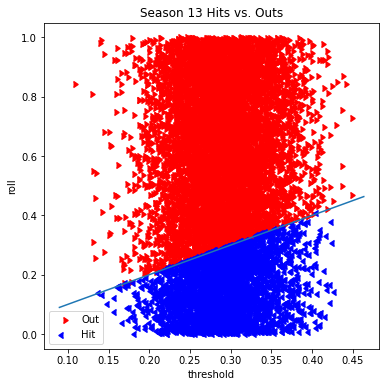

In [9]:
dfc['threshold'] = (0.315 - (
 -0.10 * dfc['batter_thwackability_with_vibe']
 +0.08 * dfc['pitcher_unthwackability_with_vibe']
 +0.07 * dfc['defense_avg_omniscience_with_vibe']
)) # this works for season 12 and 13 without ballparks

dfc['threshold'] = (0.300 - (
    - 0.10 * dfc['batter_thwackability_with_vibe']
    + 0.080 * dfc['pitcher_unthwackability_with_vibe']
    + 0.065 * dfc['defense_avg_omniscience_with_vibe']
    - 0.0115 * dfc['ballpark_grandiosity']
    - 0.008* dfc['ballpark_obtuseness']
    - 0.007* dfc['ballpark_forwardness']
    + 0.0032* dfc['ballpark_viscosity']
)) # this almost works, for season 14 and 15

# this will use the fit values
dfc['threshold'] = -intercept_scaled[0]
print(-intercept_scaled)
for pair in zip(-np.array(coef_list), X.columns):
    if pair[1] != "roll":
        print(pair)
        dfc['threshold'] += pair[0] * dfc[pair[1]]
        
    
y_val = "roll"
x_val = "threshold"
# x_val = "fielder_roll"
fig, ax = plt.subplots(1, figsize=(6, 6))
ax.scatter(dfc[~dfc['passed']][x_val], dfc[~dfc['passed']][y_val], color="red",
           label="Out", marker=CARETRIGHTBASE)
ax.scatter(dfc[dfc['passed']][x_val], dfc[dfc['passed']][y_val], color="blue",
           label="Hit", marker=CARETLEFTBASE)
ax.set_xlabel(x_val)
ax.set_ylabel('roll')
ax.set_title(f"Season {season+1} Hits vs. Outs")
# ax.set_xlim(0.484, 0.499)

if x_val == "threshold":
    ax.plot(ax.get_xlim(), ax.get_xlim())

ax.legend()

0


,offset,event_type,pitcher_mul,batter_mul,fielder_mul,event_type,roll,threshold,batter_thwackability_with_vibe,pitcher_unthwackability_with_vibe,defense_avg_omniscience_with_vibe,batter_name,pitcher_name,fielder_name,batter_mods,pitcher_mods,defender_mods,batting_team_mods,pitching_team_mods,day,game_id,play_count,fielder_roll,ballpark_obtuseness


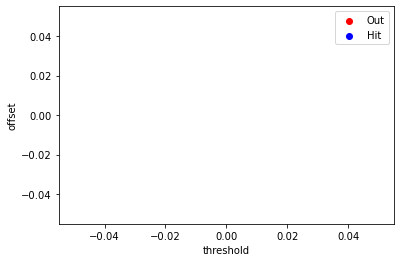

In [10]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] >= 0)) | (~dfc["passed"] & (dfc["offset"] <= 0))]

fig, ax = plt.subplots(1)
x_val = "threshold"
# x_val = "pitcher_unthwackability_with_vibe"
ax.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']]["offset"], color="red", label="Out")
ax.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']]["offset"], color="blue", label="Hit")
ax.set_xlabel(x_val)
ax.set_ylabel('offset')
ax.legend()

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
table = outliers[["offset", "event_type", #"home_score", "away_score", "top_of_inning", "inning",
       "pitcher_mul", "batter_mul", "fielder_mul",# "baserunner_count",
       "event_type", "roll", "threshold",# "batter_vibes", "pitcher_vibes",
       "batter_thwackability_with_vibe", "pitcher_unthwackability_with_vibe", "defense_avg_omniscience_with_vibe",
       "batter_name", "pitcher_name", "fielder_name", "batter_mods", "pitcher_mods", "defender_mods",
       "batting_team_mods", "pitching_team_mods", "day",  "game_id", "play_count",
       "fielder_roll", "ballpark_obtuseness"]]
print(len(table))
table.sort_values('offset', ascending=False)[0:10]


In [11]:
# outliers.sort_values('roll', ascending=True).style.hide()
dfc.groupby('fielder_name').size().sort_values(ascending=False)[0:15]

fielder_name
Basilio Fig           84
Vito Kravitz          83
Scratch Deleuze       82
Augusta Chadwell      81
Halexandrey Walton    80
Lenny Crumb           78
Stephens Lightner     78
Kaz Fiasco            77
Kurt Crueller         76
Vessalius Sundae      75
Kathy Mathews         75
Mcdowell Mason        73
Rat Mason             72
Son Scotch            71
Neerie McCloud        71
dtype: int64

In [12]:
dfc.corr()['offset'].sort_values()[0:10]

passed                           -0.783963
threshold                        -0.161608
batter_thwackability             -0.104031
batter_thwackability_with_vibe   -0.101467
batter_chasiness_with_vibe       -0.027147
batter_chasiness                 -0.026636
batter_overpowerment_with_vibe   -0.025543
batter_overpowerment             -0.025379
Unnamed: 0                       -0.023254
day                              -0.023112
Name: offset, dtype: float64

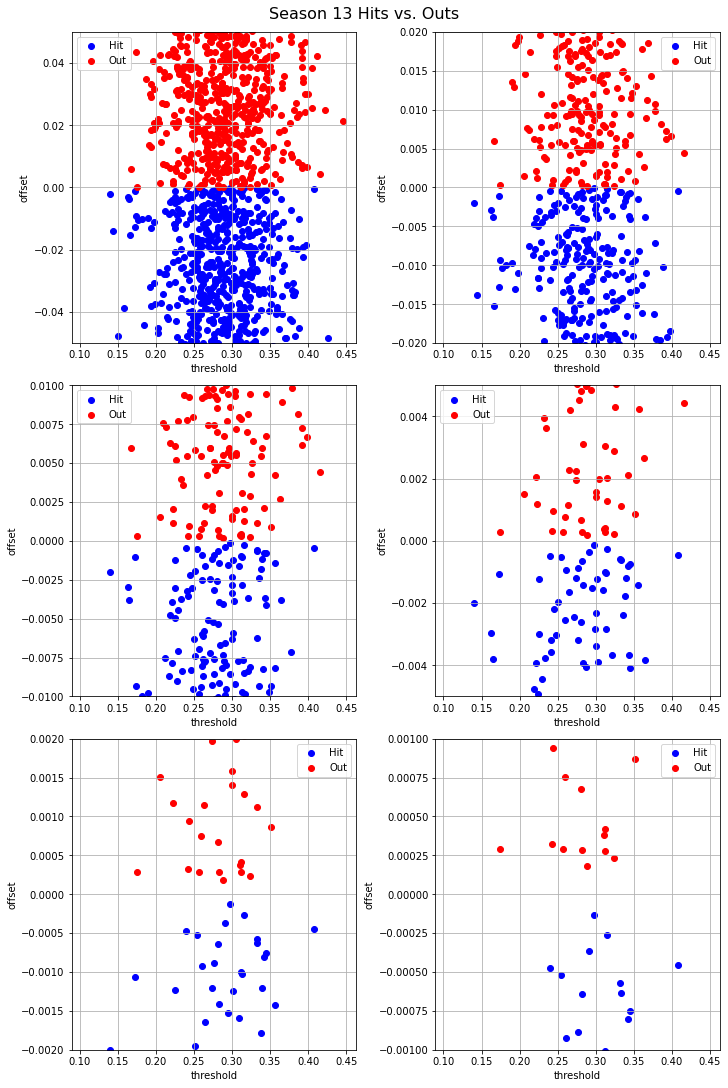

In [13]:
plt.rcParams["font.size"] = 10
x_val = 'threshold'
fig, axes = plt.subplots(3,2, figsize=(10,15), constrained_layout=True)
fig.suptitle(f"Season {season+1} Hits vs. Outs", fontsize=16)
dimlist = [5e-2, 2e-2, 1e-2, .5e-2, .2e-2, .1e-2]
for i, ax in enumerate(np.ravel(axes)):
    ax.scatter(dfc[dfc['passed']][x_val], dfc[dfc['passed']]['offset'], color="blue", label="Hit")
    ax.scatter(dfc[~dfc['passed']][x_val], dfc[~dfc['passed']]['offset'], color="red", label="Out")
    ax.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']]["offset"], color="red", edgecolor="black")
    ax.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']]["offset"], color="blue", edgecolor="black")
    ax.set_xlabel(x_val)
    ax.set_ylabel('offset')
    ax.legend()
    ax.grid()
    ax.set_ylim(-dimlist[i], dimlist[i])
# fig.savefig("hit_out_fit_offsets.png", facecolor='white')


In [14]:
dfc.groupby('baserunner_count').size().sort_values(ascending=False)[0:15]

baserunner_count
[]                                          6588
['03b80a57-77ea-4913-9be4-7a85c3594745']      39
['2b5f5dd7-e31f-4829-bec5-546652103bc0']      31
['2ffbaec8-a646-4435-a17a-3a0a2b5f3e16']      30
['678170e4-0688-436d-a02d-c0467f9af8c0']      30
['114100a4-1bf7-4433-b304-6aad75904055']      29
['2e86de11-a2dd-4b28-b5fe-f4d0c38cd20b']      29
['80e474a3-7d2b-431d-8192-2f1e27162607']      28
['c675fcdf-6117-49a6-ac32-99a89a3a88aa']      28
['cbd19e6f-3d08-4734-b23f-585330028665']      27
['63512571-2eca-4bc4-8ad9-a5308a22ae22']      27
['d8ee256f-e3d0-46cb-8c77-b1f88d8c9df9']      27
['d4a10c2a-0c28-466a-9213-38ba3339b65e']      27
['11de4da3-8208-43ff-a1ff-0b3480a0fbf1']      26
['be18d363-752d-4e4a-b06b-1a7e4641400b']      25
dtype: int64

In [15]:
max(len(x) for x in dfc.loc[:, 'baserunner_count'])

120

In [16]:
dfc.groupby('stadium_id').size()

stadium_id
cfb57d7c-4118-4b0a-85cc-4e3a51a66cb6    442
dtype: int64